<a href="https://colab.research.google.com/github/Iramira/Homework/blob/main/%D0%90%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_Buldakova_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ссылка на GitHub и ссылка на презентацию: https://docs.google.com/presentation/d/1SGICiAeaSFK2MObaGY5mPDXPEWVE7sCp/edit?usp=sharing&ouid=116907206108487001261&rtpof=true&sd=true


Аттестационная работа

Covid-19 forecasting COVID-19 - это вызывающий заболевание штамм коронавируса, появившийся в декабре 2019 года и приведший к продолжающейся глобальной пандемии. Возможность предвидеть путь пандемии имеет решающее значение. Это важно для того, чтобы определить, как бороться, и отследить его распространение.

Введение. Постановка целей и задач. Провести анализ данных о заболеваемости, предложить и настроить прогностическую модель, выполнить прогноз и сравнить результаты с новой статистикой (полученной после 5 апреля 2021 года)

Импортируем библиотеки, скачиваем realtime data по ссылке https://github.com/owid/covid-19-data/tree/master/public/data

In [2]:
!pip install nbconvert
import nbconvert
!pip install pmdarima
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima  
from pandas.plotting import lag_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

url = 'https://drive.google.com/file/d/16W2HAMywdXKK4AA9yr6ufMciJ_4D2QwJ/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_csv(path, delimiter=',' )

Знакомимся с данными с помощью функций head, count, info

In [3]:
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
df.count()

iso_code                                   148106
continent                                  139164
location                                   148106
date                                       148106
total_cases                                145506
                                            ...  
human_development_index                    121559
excess_mortality_cumulative_absolute         5050
excess_mortality_cumulative                  5050
excess_mortality                             5050
excess_mortality_cumulative_per_million      5050
Length: 67, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148106 entries, 0 to 148105
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    148106 non-null  object 
 1   continent                                   139164 non-null  object 
 2   location                                    148106 non-null  object 
 3   date                                        148106 non-null  object 
 4   total_cases                                 145506 non-null  float64
 5   new_cases                                   145500 non-null  float64
 6   new_cases_smoothed                          144355 non-null  float64
 7   total_deaths                                128558 non-null  float64
 8   new_deaths                                  128754 non-null  float64
 9   new_deaths_smoothed                         144355 non-null  float64
 

Предобработка данных: нам даны 67 колонок данных по 160 странам, чтобы провести анализ данных и сделать прогноз ситуации по covid-19 - сделаем выборку данных по одной стране (Катар)

In [6]:
df = df[df.location=='Qatar']

In [7]:
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
108891,QAT,Asia,Qatar,2020-02-29,1.0,1.0,NaN,NaN,NaN,NaN,0.341,0.341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,13.8,3.67,7.9,4.709055
108892,QAT,Asia,Qatar,2020-03-01,3.0,2.0,NaN,NaN,NaN,NaN,1.024,0.682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
108893,QAT,Asia,Qatar,2020-03-02,3.0,0.0,NaN,NaN,NaN,NaN,1.024,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
108894,QAT,Asia,Qatar,2020-03-03,7.0,4.0,NaN,NaN,NaN,NaN,2.389,1.365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
108895,QAT,Asia,Qatar,2020-03-04,8.0,1.0,NaN,NaN,NaN,NaN,2.730,0.341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109544,QAT,Asia,Qatar,2021-12-13,245523.0,169.0,162.286,613.0,0.0,0.286,83781.262,57.669,55.378,209.178,0.000,0.097,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5077164.0,NaN,NaN,NaN,NaN,8320.0,173.25,NaN,NaN,NaN,2839.0,NaN,NaN,52.78,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
109545,QAT,Asia,Qatar,2021-12-14,245690.0,167.0,163.571,613.0,0.0,0.286,83838.249,56.986,55.816,209.178,0.000,0.097,1.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5088710.0,NaN,NaN,NaN,11546.0,8637.0,173.65,NaN,NaN,NaN,2947.0,NaN,NaN,NaN,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.2

Построим график

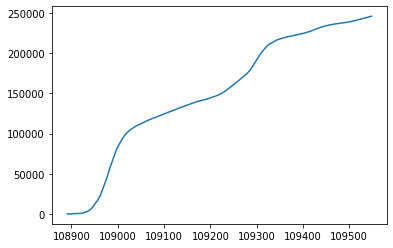

In [8]:
df[df.location=='Qatar'].total_cases.plot()

In [9]:
df_lim = df[df.location=='Qatar']
df_lim

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
108891,QAT,Asia,Qatar,2020-02-29,1.0,1.0,NaN,NaN,NaN,NaN,0.341,0.341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,13.8,3.67,7.9,4.709055
108892,QAT,Asia,Qatar,2020-03-01,3.0,2.0,NaN,NaN,NaN,NaN,1.024,0.682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
108893,QAT,Asia,Qatar,2020-03-02,3.0,0.0,NaN,NaN,NaN,NaN,1.024,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
108894,QAT,Asia,Qatar,2020-03-03,7.0,4.0,NaN,NaN,NaN,NaN,2.389,1.365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
108895,QAT,Asia,Qatar,2020-03-04,8.0,1.0,NaN,NaN,NaN,NaN,2.730,0.341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109544,QAT,Asia,Qatar,2021-12-13,245523.0,169.0,162.286,613.0,0.0,0.286,83781.262,57.669,55.378,209.178,0.000,0.097,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5077164.0,NaN,NaN,NaN,NaN,8320.0,173.25,NaN,NaN,NaN,2839.0,NaN,NaN,52.78,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
109545,QAT,Asia,Qatar,2021-12-14,245690.0,167.0,163.571,613.0,0.0,0.286,83838.249,56.986,55.816,209.178,0.000,0.097,1.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5088710.0,NaN,NaN,NaN,11546.0,8637.0,173.65,NaN,NaN,NaN,2947.0,NaN,NaN,NaN,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.2

Удалим малоинформативные колонки данных, и оставим 5 наиболее важных для анализа и построения моделей прогнозирования:
- дата 
- общее количество случаев
- новые случаи заболеваний
- общее количество смертности
- новые случаи смертности

In [10]:
df_lim2 = df_lim[['date',	'total_cases',	'new_cases',	'total_deaths',	'new_deaths']]
df_lim2

,date,total_cases,new_cases,total_deaths,new_deaths
108891,2020-02-29,1.0,1.0,NaN,NaN
108892,2020-03-01,3.0,2.0,NaN,NaN
108893,2020-03-02,3.0,0.0,NaN,NaN
108894,2020-03-03,7.0,4.0,NaN,NaN
108895,2020-03-04,8.0,1.0,NaN,NaN
...,...,...,...,...,...
109544,2021-12-13,245523.0,169.0,613.0,0.0
109545,2021-12-14,245690.0,167.0,613.0,0.0
109546,2021-12-15,245855.0,165.0,614.0,1.0
109547,2021-12-16,246024.0,169.0,614.0,0.0


Выявим и устраним пропуски

In [11]:
df_lim2.isnull().sum()

date             0
total_cases      0
new_cases        0
total_deaths    28
new_deaths      28
dtype: int64

In [12]:
df1 = df_lim2.fillna(0)
df1

,date,total_cases,new_cases,total_deaths,new_deaths
108891,2020-02-29,1.0,1.0,0.0,0.0
108892,2020-03-01,3.0,2.0,0.0,0.0
108893,2020-03-02,3.0,0.0,0.0,0.0
108894,2020-03-03,7.0,4.0,0.0,0.0
108895,2020-03-04,8.0,1.0,0.0,0.0
...,...,...,...,...,...
109544,2021-12-13,245523.0,169.0,613.0,0.0
109545,2021-12-14,245690.0,167.0,613.0,0.0
109546,2021-12-15,245855.0,165.0,614.0,1.0
109547,2021-12-16,246024.0,169.0,614.0,0.0


In [13]:
df1.duplicated()

108891    False
108892    False
108893    False
108894    False
108895    False
          ...  
109544    False
109545    False
109546    False
109547    False
109548    False
Length: 658, dtype: bool

Пропуски устранены, дубликаты не обнаружены.

EDA или разведочный анализ данных.

Определяем ключевым столбцом (index) дату стат. показателей в Df1, т.к. далее будем работать с временными рядами, а также меняем тип данных (time) в указанном столбце на подходящий нам для дальнейшей работы

In [14]:
df1['date']=df1['date'].astype('datetime64')
df1.index=df1.date
df1.info()
df1

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 658 entries, 2020-02-29 to 2021-12-17
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          658 non-null    datetime64[ns]
 1   total_cases   658 non-null    float64       
 2   new_cases     658 non-null    float64       
 3   total_deaths  658 non-null    float64       
 4   new_deaths    658 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 30.8 KB


,date,total_cases,new_cases,total_deaths,new_deaths
date,,,,,
2020-02-29,2020-02-29,1.0,1.0,0.0,0.0
2020-03-01,2020-03-01,3.0,2.0,0.0,0.0
2020-03-02,2020-03-02,3.0,0.0,0.0,0.0
2020-03-03,2020-03-03,7.0,4.0,0.0,0.0
2020-03-04,2020-03-04,8.0,1.0,0.0,0.0
...,...,...,...,...,...
2021-12-13,2021-12-13,245523.0,169.0,613.0,0.0
2021-12-14,2021-12-14,245690.0,167.0,613.0,0.0
2021-12-15,2021-12-15,245855.0,165.0,614.0,1.0


Выведем основную статистику

In [15]:
df1.describe()

,total_cases,new_cases,total_deaths,new_deaths
count,658.000000,658.000000,658.000000,658.000000
mean,151546.788754,374.145897,322.044073,0.933131
std,74536.244723,391.244722,217.035596,1.665780
min,1.000000,0.000000,0.000000,0.000000
25%,113719.000000,151.000000,188.500000,0.000000
50%,148646.500000,218.500000,248.000000,0.000000
75%,222736.750000,459.000000,593.750000,1.000000
max,246188.000000,2355.000000,614.000000,10.000000


Стат.показатель 'mean' показывает, что среднее значение новых случаев заболеваний составляет 374, а количество новых смертельных случаев ежедневно составляет 0,9.

Стат.показатель 'max' показывает, что ежедневно выявляется до 2355 случаев заболеваний, а смертность составляет максимум 10.

Построим графики новых случаев заболеваний и новых смертельных случаев, посмотрим на их корреляцию.

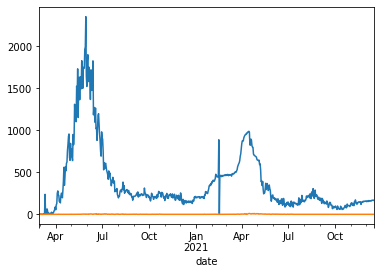

In [16]:
df1.new_cases.plot()
df1.new_deaths.plot()

In [17]:
df1.corr()

,total_cases,new_cases,total_deaths,new_deaths
total_cases,1.000000,-0.360575,0.958554,0.040865
new_cases,-0.360575,1.000000,-0.431876,0.429159
total_deaths,0.958554,-0.431876,1.000000,-0.033845
new_deaths,0.040865,0.429159,-0.033845,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f54e939e490>,
      dtype=object)

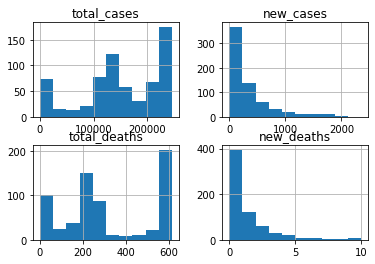

In [18]:
df1.hist()

на пересечении new_cases и new_deaths наблюдается корреляция

Text(0.5, 1.0, 'Новые случаи смертности')

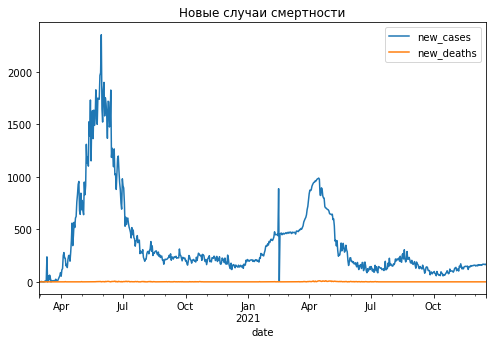

In [19]:
df1.new_cases.plot(figsize=(8,5) , legend=True)
plt.title("Новые случаи заболеваний") 
df1.new_deaths.plot(figsize=(8,5) , legend=True)
plt.title("Новые случаи смертности")

Для построения моделей и прогнозирования результатов используем: 
SARIMA и Экспоненциальную модель Holt-Winters' Model

Выполним ETS декомпозицию, используя аддитивную модель ('additive').

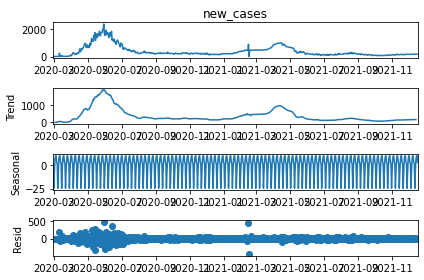

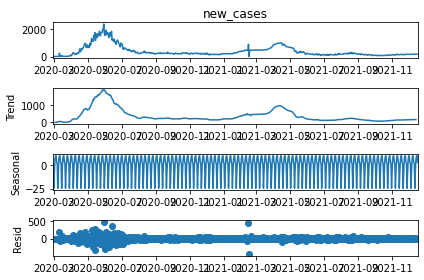

In [20]:
df2 = seasonal_decompose(df1['new_cases'], model='additive')
df2.plot()

Для определения значения факторов (p,d,q)(P,D,Q)s воспользуемся auto_arima:

In [21]:
auto_arima(df1['new_cases'], seasonal=True, m=2).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  658
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 2)   Log Likelihood               -3817.758
Date:                                Tue, 21 Dec 2021   AIC                           7647.517
Time:                                        15:24:44   BIC                           7674.443
Sample:                                             0   HQIC                          7657.956
                                                - 658                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3393      0.227     -1.493      0.135      -0.785       0.106
ma.L1         -0.2503      0.227     -1.104      0.270      -0.695       0.194
ar.S.L2        0.8982      0.027     32.738      0.000       0.844       0.952
ma.S.L2       -1.0746      0.116     -9.235      0.000      -1.303      -0.846
ma.S.L4        0.2355      0.107      2.199      0.028       0.026       0.445
sigma2      6521.1152    134.938     48.327      0.000    6256.641    6785.590
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6626.01
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
df1.index.freq = 'D'
print(len(df1))
print(df1.head())

658
                 date  total_cases  new_cases  total_deaths  new_deaths
date                                                                   
2020-02-29 2020-02-29          1.0        1.0           0.0         0.0
2020-03-01 2020-03-01          3.0        2.0           0.0         0.0
2020-03-02 2020-03-02          3.0        0.0           0.0         0.0
2020-03-03 2020-03-03          7.0        4.0           0.0         0.0
2020-03-04 2020-03-04          8.0        1.0           0.0         0.0


Установим 10 дней для тестирования. 

In [23]:
train = df1.iloc[:len(df1)-10]
test = df1.iloc[len(df1)-10:]

In [24]:
model = SARIMAX(train['new_cases'], order=(1, 0, 1), seasonal_order=(2, 1, [1,2], 2) )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              new_cases   No. Observations:                  648
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 2)   Log Likelihood               -3764.184
Date:                                Tue, 21 Dec 2021   AIC                           7542.368
Time:                                        15:26:48   BIC                           7573.664
Sample:                                    02-29-2020   HQIC                          7554.510
                                         - 12-07-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5339      0.016    -33.200      0.000      -0.565      -0.502
ma.L1          0.9996      0.062     16.099      0.000       0.878       1.121
ar.S.L2       -0.0384      0.065     -0.591      0.555      -0.166       0.089
ar.S.L4       -0.6325      0.045    -13.992      0.000      -0.721      -0.544
ma.S.L2       -0.2074      0.066     -3.127      0.002      -0.337      -0.077
ma.S.L4        0.6724      0.044     15.316      0.000       0.586       0.758
sigma2      6682.1637    373.522     17.890      0.000    5950.075    7414.253
===================================================================================
Ljung-Box (L1) (Q):                   1.14   Jarque-Bera (JB):              5764.99
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Получили прогнозируемые значения

In [25]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(0, 1, 0)x(2, 0, [0], 12)')

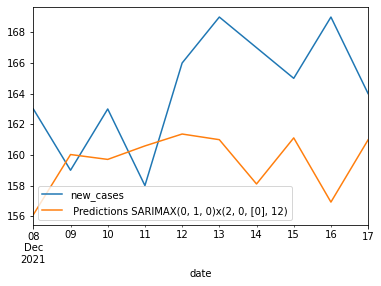

In [26]:
test['new_cases'].plot(legend=True)
predictions.plot(legend=True)

In [27]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 12)')

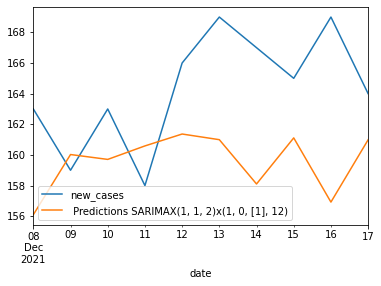

In [28]:
test['new_cases'].plot(legend=True)
predictions.plot(legend=True)

выводим первые 5 значений для test, predictions и train

In [29]:
predictions.head()

2021-12-08    156.097198
2021-12-09    160.025528
2021-12-10    159.707292
2021-12-11    160.587598
2021-12-12    161.364464
Freq: D, Name:  Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 12), dtype: float64

In [30]:
test['new_cases'].head()

date
2021-12-08    163.0
2021-12-09    159.0
2021-12-10    163.0
2021-12-11    158.0
2021-12-12    166.0
Freq: D, Name: new_cases, dtype: float64

In [31]:
train['new_cases'].head()

date
2020-02-29    1.0
2020-03-01    2.0
2020-03-02    0.0
2020-03-03    4.0
2020-03-04    1.0
Freq: D, Name: new_cases, dtype: float64

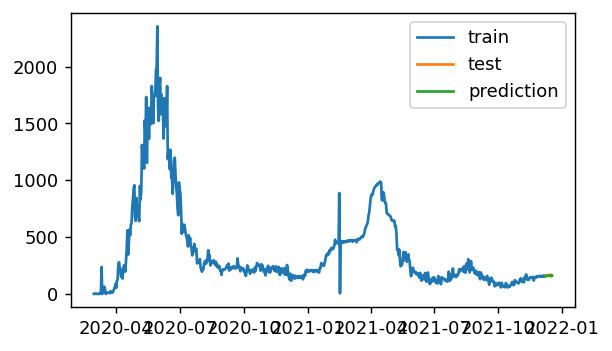

In [32]:
plt.figure(figsize=(5,3), dpi=130)
plt.plot(train['new_cases'], label='train')
plt.plot(test['new_cases'], label='test')
plt.plot(predictions, label='prediction')
plt.legend()
plt.show()

Оценим качество модели SARIMA с помощью MAE, MAPE и MSE 

In [33]:
print('Расчет точности полученного прогноза')
print('MAE:', mean_absolute_error(test['new_cases'], predictions))
print('MAPE:', mean_absolute_percentage_error(test['new_cases'], predictions))
print('MSE:', mean_squared_error(test['new_cases'], predictions))

Расчет точности полученного прогноза
MAE: 5.432437075491331
MAPE: 0.032734152971652115
MSE: 40.103385707227716


В целом, модель прогнозирования на 10 дней подтверждает, что волна новых заболеваний и случаев смертности ещё не закончилась.

Экспоненциальное сглаживание - модель Хольта-Винтера (Holt-Winters' Model)

In [34]:
start=len(train)
end=len(train)+len(test)-1
predictions_hw = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1, 0, 0)x(0, 1, [1,2], 2) ')
predictions_hw

2021-12-08    156.097198
2021-12-09    160.025528
2021-12-10    159.707292
2021-12-11    160.587598
2021-12-12    161.364464
2021-12-13    160.994911
2021-12-14    158.104321
2021-12-15    161.111290
2021-12-16    156.921090
2021-12-17    160.988190
Freq: D, Name: SARIMA(1, 0, 0)x(0, 1, [1,2], 2) , dtype: float64

In [35]:
model_hw = ExponentialSmoothing(train['new_cases'], trend='add',seasonal='add',seasonal_periods=2).fit()

In [36]:
predictions_hw = model_hw.predict(start=start, end=end)

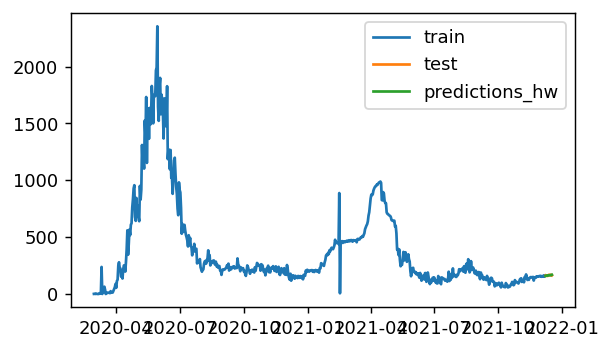

In [37]:
plt.figure(figsize=(5,3), dpi=130)
plt.plot(train['new_cases'], label='train')
plt.plot(test['new_cases'], label='test')
plt.plot(predictions_hw, label='predictions_hw')
plt.legend()
plt.show()

Оценим качество модели Хольта-Винтера с помощью MAE, MAPE и MSE 

In [38]:
print('Рассчет точности полученного прогноза')
print('MAE:', mean_absolute_error(test['new_cases'], predictions_hw))
print('MAPE:', mean_absolute_percentage_error(test['new_cases'], predictions_hw))
print('MSE:', mean_squared_error(test['new_cases'], predictions_hw))

Рассчет точности полученного прогноза
MAE: 3.620401279815977
MAPE: 0.022098434396179333
MSE: 14.158011594557271


Модель Хольта-Винтера показала меньшую погрешность прогнозирования, чем модель SARIMAX. Значит, в данном случае надо опираться на данные модели  Хольта-Винтера.

Попробуем еще проанализировать данные другим способом

In [39]:
df = pd.read_csv('./owid-covid-data.csv', index_col='date', parse_dates = True)
df

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-16,ZWE,Africa,Zimbabwe,182057.0,4367.0,3748.571,4759.0,14.0,5.143,12063.009,289.355,248.379,315.329,0.928,0.341,1.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12390.0,1622279.0,107.491,0.821,12471.0,0.826,0.3006,3.3,tests performed,7058474.0,4023289.0,3035185.0,NaN,45074.0,26738.0,46.77,26.66,20.11,NaN,1772.0,14047.0,0.093,63.89,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
2021-12-17,ZWE,Africa,Zimbabwe,189567.0,7510.0,4821.429,4779.0,20.0,8.000,12560.618,497.609,319.466,316.654,1.325,0.530,1.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9483.0,1631762.0,108.120,0.628,11700.0,0.775,0.4121,2.4,tests p

In [40]:
df.location.value_counts().index

Index(['Argentina', 'Mexico', 'Peru', 'Thailand', 'Taiwan', 'South Korea',
       'Upper middle income', 'Macao', 'Lower middle income', 'North America',
       ...
       'Sint Maarten (Dutch part)', 'Kiribati', 'Cook Islands', 'Turkmenistan',
       'Tuvalu', 'Nauru', 'Palau', 'Tokelau', 'Pitcairn', 'Niue'],
      dtype='object', length=238)

In [41]:
df = df[df.location=='Qatar']

In [42]:
df

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-29,QAT,Asia,Qatar,1.0,1.0,NaN,NaN,NaN,NaN,0.341,0.341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,13.8,3.67,7.9,4.709055
2020-03-01,QAT,Asia,Qatar,3.0,2.0,NaN,NaN,NaN,NaN,1.024,0.682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
2020-03-02,QAT,Asia,Qatar,3.0,0.0,NaN,NaN,NaN,NaN,1.024,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
2020-03-03,QAT,Asia,Qatar,7.0,4.0,NaN,NaN,NaN,NaN,2.389,1.365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
2020-03-04,QAT,Asia,Qatar,8.0,1.0,NaN,NaN,NaN,NaN,2.730,0.341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.89,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-16,QAT,Asia,Qatar,246024.0,169.0,165.286,614.0,0.0,0.429,83952.222,57.669,56.401,209.519,0.0,0.146,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8357.0,NaN,NaN,NaN,NaN,2852.0,NaN,NaN,55.56,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,0.848,NaN,NaN,NaN,NaN
2021-12-17,QAT,Asia,Qatar,246188.0,164.0,165.429,614.0,0.0,0.286,84008.184,55.963,56.450,209.519,0.0,0.097,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5105894.0,NaN,NaN,NaN,NaN,7717.0,174.23,NaN,NaN,NaN,2633.0,NaN,NaN,55.56,2930524.0,227.322,31.9,1.307,0.617,116935.6,NaN,176.69,16.52,0.8,26.9,NaN,1.2,80.23,

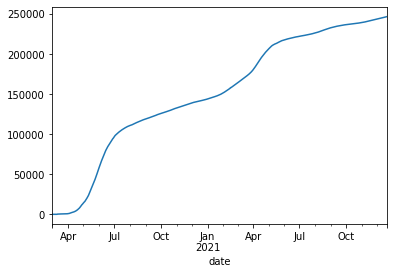

In [43]:
df[df.location=='Qatar'].total_cases.plot()

In [44]:
df.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,661.000000,661.000000,656.000000,633.000000,633.000000,656.000000,661.000000,661.000000,656.000000,633.000000,633.000000,656.000000,647.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,580.000000,5.880000e+02,588.000000,580.000000,588.000000,588.000000,0.0,0.0,2.580000e+02,1.260000e+02,1.250000e+02,0.0,229.000000,363.000000,258.000000,126.000000,125.000000,0.0,363.000000,206.000000,206.000000,661.000000,661.0,6.610000e+02,6.610000e+02,6.610000e+02,6.610000e+02,6.610000e+02,0.0,6.610000e+02,6.610000e+02,6.610000e+02,6.610000e+02,0.0,6.610000e+02,6.610000e+02,6.610000e+02,21.000000,21.000000,21.000000,21.000000
mean,151977.919818,373.243570,375.294651,337.672986,0.969984,0.935828,51860.322536,127.364116,128.064023,115.226137,0.330915,0.319227,1.023509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4739.227586,1.296860e+06,442.535260,1.617191,4738.491497,1.616930,NaN,NaN,3.331890e+06,1.722645e+06,1.405430e+06,NaN,18136.126638,14075.030303,113.695930,58.782857,47.958400,NaN,4802.939394,11100.364078,0.378743,65.205764,2930524.0,2.273220e+02,3.190000e+01,1.307000e+00,6.170000e-01,1.169356e+05,NaN,1.766900e+02,1.652000e+01,8.000000e-01,2.690000e+01,NaN,1.200000e+00,8.023000e+01,8.480000e-01,441.790476,17.398571,22.749048,150.754772
std,74640.666122,390.583623,385.085202,211.028124,1.687833,1.434680,25470.075012,133.281155,131.404896,72.010355,0.575928,0.489558,0.258335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1370.599397,8.503872e+05,290.182621,0.467695,1210.719348,0.413164,NaN,NaN,1.477394e+06,4.252448e+05,4.512688e+05,NaN,11242.821154,10087.424704,50.413955,14.510853,15.399215,NaN,3442.182982,3508.616286,0.119697,13.899080,0.0,1.763480e-12,1.244391e-13,9.999574e-15,4.444255e-15,1.165035e-10,NaN,1.507491e-12,2.666553e-13,6.221957e-15,1.244391e-13,NaN,1.088843e-14,9.812915e-13,4.999787e-15,292.999124,6.411489,28.620796,99.981820
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.341000,0.000000,0.341000,0.341000,0.000000,0.000000,0.460000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.000000,5.309000e+03,1.812000,0.059000,415.000000,0.142000,NaN,NaN,0.000000e+00,1.000000e+05,5.549820e+05,NaN,1214.000000,1351.000000,0.000000,3.410000,18.940000,NaN,461.000000,2051.000000,0.070000,13.890000,2930524.0,2.273220e+02,3.190000e+01,1.307000e+00,6.170000e-01,1.169356e+05,NaN,1.766900e+02,1.652000e+01,8.000000e-01,2.690000e+01,NaN,1.200000e+00,8.023000e+01,8.480000e-01,13.800000,3.670000,-14.420000,4.709055
25%,113938.000000,151.000000,151.678250,199.000000,0.000000,0.143000,38879.736000,51.527000,51.758000,67.906000,0.000000,0.049000,0.880000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4085.500000,5.161012e+05,176.112000,1.394500,4234.750000,1.444750,NaN

Посмотрим содержание столбцов

In [45]:
df.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vac

Возьмем для отображения следующие параметры: "общее количество случаев", "новые случаи", "общее количество смертей", "новое количество смертей","общее количество случаев заболевания на один миллион", "новые случаи заболевания на один миллион", "общее количество смертей на один миллион". "новое количество смертей на один миллион"

In [46]:
df1 = df[['total_cases', 'new_cases',
       'total_deaths', 'new_deaths',
       'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million',]]

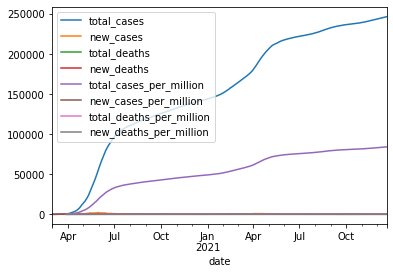

In [47]:
df1.plot()

Возьмем для отображения следующие параметры:  "новые случаи", "общее количество смертей", "новое количество смертей","общее количество случаев заболевания на один миллион", "новые случаи заболевания на один миллион", "общее количество смертей на один миллион". "новое количество смертей на один миллион"

In [48]:
df2 = df[['new_cases',
       'total_deaths', 'new_deaths',
       'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million',]]

In [49]:
df2

,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million
date,,,,,,,
2020-02-29,1.0,NaN,NaN,0.341,0.341,NaN,NaN
2020-03-01,2.0,NaN,NaN,1.024,0.682,NaN,NaN
2020-03-02,0.0,NaN,NaN,1.024,0.000,NaN,NaN
2020-03-03,4.0,NaN,NaN,2.389,1.365,NaN,NaN
2020-03-04,1.0,NaN,NaN,2.730,0.341,NaN,NaN
...,...,...,...,...,...,...,...
2021-12-16,169.0,614.0,0.0,83952.222,57.669,209.519,0.0
2021-12-17,164.0,614.0,0.0,84008.184,55.963,209.519,0.0
2021-12-18,179.0,614.0,0.0,84069.265,61.081,209.519,0.0


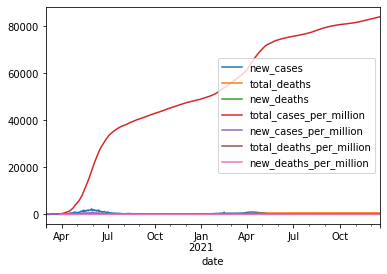

In [50]:
df2.plot()

Спрогнозируем общее количество заболевших на один миллион человек


In [51]:
df3 = df[['total_cases_per_million']]

In [52]:
df3

,total_cases_per_million
date,
2020-02-29,0.341
2020-03-01,1.024
2020-03-02,1.024
2020-03-03,2.389
2020-03-04,2.730
...,...
2021-12-16,83952.222
2021-12-17,84008.184
2021-12-18,84069.265


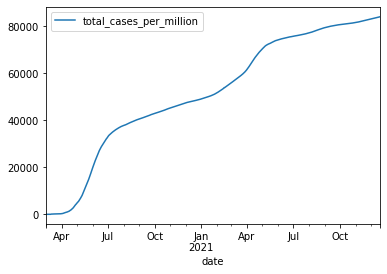

In [53]:
df3.plot()

Количество заболевших возрастает

Гипотеза: общее количество случаев заболевших на миллион человек после 5 апреля 2021 года: с 5 апреля по 5 мая

In [54]:
df4 = df3[:'2021-04-05']

Собираем исторические данные

In [55]:
df4

,total_cases_per_million
date,
2020-02-29,0.341
2020-03-01,1.024
2020-03-02,1.024
2020-03-03,2.389
2020-03-04,2.730
...,...
2021-04-01,61696.816
2021-04-02,61995.056
2021-04-03,62291.931


Проводим предварительный разведочный анализ данных

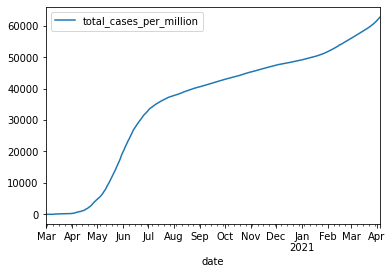

In [56]:
df4.plot()

Определяем наличие тренда и сезонности

Выполним декомпозицию

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [58]:
r = seasonal_decompose(df4['total_cases_per_million'],model='additive')

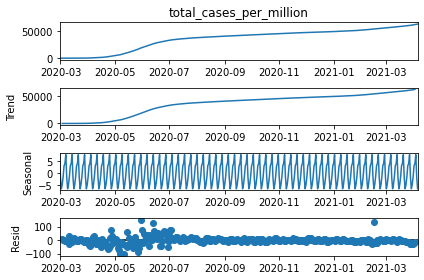

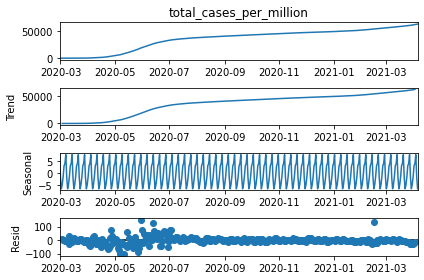

In [59]:
r.plot()

Тренд возрастает, сезонная компонента плюс/минус 5, диапазон от 0 до 60000, сезонные колебания выделяются в районе 5 дней, остатки колеблются в районе от - 100 до 100 дней

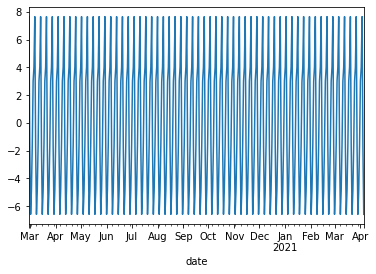

In [60]:
r.seasonal.plot()

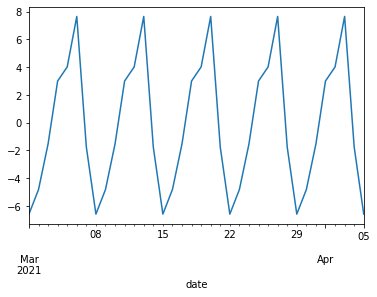

In [61]:
r.seasonal['2021-03-01':'2021-04-30'].plot()

Наблюдаем недельные колебания от плюс 8 до минус 6 человек

Остатки

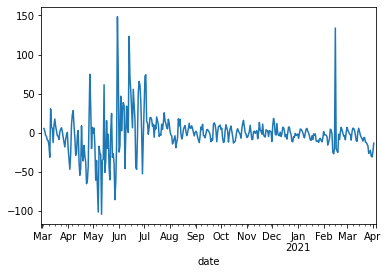

In [62]:
r.resid.plot()

Остатки (плюс 150, минус 100) превышают сезонность. Сезонность хоть и выделена, но меньше, чем случайные колебания

Выбираем модель ARIMA

In [63]:
auto_arima(df4['total_cases_per_million'],seasonal=True,d=7).summary()

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning:

Error fitting  ARIMA(5,7,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py", line 512, in _fit_wrapper
    **fit_args)
  File "/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 709, in fit
    skip_hessian=True, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py", line

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  402
Model:               SARIMAX(5, 7, 0)   Log Likelihood               -2517.204
Date:                Tue, 21 Dec 2021   AIC                           5046.409
Time:                        15:49:41   BIC                           5070.282
Sample:                             0   HQIC                          5055.867
                                - 402                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.7351      0.018   -154.284      0.000      -2.770      -2.700
ar.L2         -3.8714      0.046    -85.055      0.000      -3.961      -3.782
ar.L3         -3.4869      0.062    -56.375      0.000      -3.608      -3.366
ar.L4         -1.9935      0.050    -39.587      0.000      -2.092      -1.895
ar.L5         -0.5878      0.021    -27.808      0.000      -0.629      -0.546
sigma2      1.995e+04    599.323     33.279      0.000    1.88e+04    2.11e+04
===================================================================================
Ljung-Box (L1) (Q):                  40.25   Jarque-Bera (JB):              1815.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Разбиваем выборку на обучающую и тестовую

In [64]:
train = df4[:'2021-03-05']
test = df4['2021-03-06':]

In [65]:
train

,total_cases_per_million
date,
2020-02-29,0.341
2020-03-01,1.024
2020-03-02,1.024
2020-03-03,2.389
2020-03-04,2.730
...,...
2021-03-01,56009.437
2021-03-02,56167.429
2021-03-03,56328.152


In [66]:
test

,total_cases_per_million
date,
2021-03-06,56807.247
2021-03-07,56968.993
2021-03-08,57128.691
2021-03-09,57289.413
2021-03-10,57450.818
2021-03-11,57610.516
2021-03-12,57765.778
2021-03-13,57930.595
2021-03-14,58096.095


In [67]:
model = SARIMAX(train['total_cases_per_million'],order=(5, 7, 0),seasonal_order=(1, 0, 1, 7))
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             total_cases_per_million   No. Observations:                  371
Model:             SARIMAX(5, 7, 0)x(1, 0, [1], 7)   Log Likelihood               -2323.031
Date:                             Tue, 21 Dec 2021   AIC                           4662.062
Time:                                     15:50:07   BIC                           4693.240
Sample:                                 02-29-2020   HQIC                          4674.454
                                      - 03-05-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.7740      0.023   -118.843      0.000      -2.820      -2.728
ar.L2         -3.9493      0.059    -66.539      0.000      -4.066      -3.833
ar.L3         -3.6284      0.082    -44.055      0.000      -3.790      -3.467
ar.L4         -2.1162      0.069    -30.449      0.000      -2.252      -1.980
ar.L5         -0.5845      0.029    -20.368      0.000      -0.641      -0.528
ar.S.L7       -0.3619      0.095     -3.826      0.000      -0.547      -0.176
ma.S.L7       -0.0318      0.125     -0.253      0.800      -0.277       0.214
sigma2      2.028e+04    762.875     26.579      0.000    1.88e+04    2.18e+04
===================================================================================
Ljung-Box (L1) (Q):                  24.80   Jarque-Bera (JB):              1142.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Делаем прогноз

In [68]:
predictions = results.predict(start='2021-03-06', end='2021-04-05', dynamic=False, typ='levels').rename('Predictions')

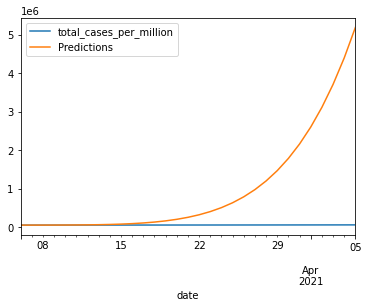

In [69]:
test['total_cases_per_million'].plot(legend=True)
predictions.plot(legend=True)

Прогноз на неделю хороший, затем ухудшается

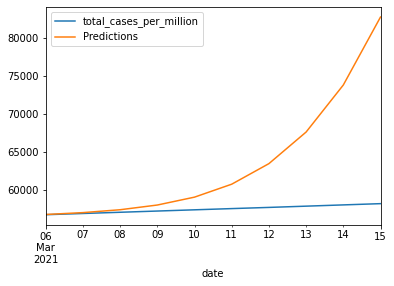

In [70]:
test['total_cases_per_million']['2021-03-06':'2021-03-15'].plot(legend=True,)
predictions['2021-03-06':'2021-03-15'].plot(legend=True)